In [ ]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor 
import joblib
import optuna

In [3]:
# Load datasets
pesticides_path = 'data/pesticides.csv'
rainfall_path = 'data/rainfall.csv'
temp_path = 'data/temp.csv'
yield_path = 'data/yield.csv'

In [4]:
pesticides_df = pd.read_csv(pesticides_path)
rainfall_df = pd.read_csv(rainfall_path)
temp_df = pd.read_csv(temp_path)
yield_df = pd.read_csv(yield_path)

In [5]:
#view yield dataset details
yield_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


In [6]:
# drop unwanted columns.
yield_df = yield_df.drop(['Year Code','Element Code','Element','Year Code','Area Code','Domain Code','Domain','Unit','Item Code'], axis=1)
yield_df.head()

,Area,Item,Year,Value
0,Afghanistan,Maize,1961,14000
1,Afghanistan,Maize,1962,14000
2,Afghanistan,Maize,1963,14260
3,Afghanistan,Maize,1964,14257
4,Afghanistan,Maize,1965,14400


In [7]:
yield_df.describe()

,Year,Value
count,56717.000000,56717.000000
mean,1989.669570,62094.660084
std,16.133198,67835.932856
min,1961.000000,0.000000
25%,1976.000000,15680.000000
50%,1991.000000,36744.000000
75%,2004.000000,86213.000000
max,2016.000000,1000000.000000


In [8]:
yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56717 entries, 0 to 56716
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Area    56717 non-null  object
 1   Item    56717 non-null  object
 2   Year    56717 non-null  int64 
 3   Value   56717 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.7+ MB


In [9]:
#view rainfall dataset details
rainfall_df.head()

,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327


In [10]:
rainfall_df = rainfall_df.rename(index=str, columns={" Area": 'Area'})

In [11]:
# check data types 
rainfall_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Area                           6727 non-null   object
 1   Year                           6727 non-null   int64 
 2   average_rain_fall_mm_per_year  5953 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.2+ KB


In [12]:
# convert average_rain_fall_mm_per_year from object to float
rainfall_df['average_rain_fall_mm_per_year'] = pd.to_numeric(rainfall_df['average_rain_fall_mm_per_year'],errors = 'coerce')
rainfall_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           6727 non-null   object 
 1   Year                           6727 non-null   int64  
 2   average_rain_fall_mm_per_year  5947 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 210.2+ KB


In [13]:
#dropping null value rows
rainfall_df = rainfall_df.dropna()

In [14]:
rainfall_df.describe()

,Year,average_rain_fall_mm_per_year
count,5947.000000,5947.000000
mean,2001.365899,1124.743232
std,9.526335,786.257365
min,1985.000000,51.000000
25%,1993.000000,534.000000
50%,2001.000000,1010.000000
75%,2010.000000,1651.000000
max,2017.000000,3240.000000


In [15]:
# merge yield dataframe with rain dataframe by year and area columns 
yield_df = pd.merge(yield_df, rainfall_df, on=['Year','Area'])

In [16]:
yield_df.shape

(25385, 5)

In [17]:
yield_df.head()

,Area,Item,Year,Value,average_rain_fall_mm_per_year
0,Afghanistan,Maize,1985,16652,327.0
1,Afghanistan,Potatoes,1985,140909,327.0
2,Afghanistan,"Rice, paddy",1985,22482,327.0
3,Afghanistan,Wheat,1985,12277,327.0
4,Afghanistan,Maize,1986,16875,327.0


In [18]:
yield_df.describe()

,Year,Value,average_rain_fall_mm_per_year
count,25385.000000,25385.000000,25385.000000
mean,2001.278787,68312.278353,1254.849754
std,9.143915,75213.292733,804.449430
min,1985.000000,50.000000,51.000000
25%,1994.000000,17432.000000,630.000000
50%,2001.000000,38750.000000,1150.000000
75%,2009.000000,94286.000000,1761.000000
max,2016.000000,554855.000000,3240.000000


In [19]:
#pesticides dataset info
pesticides_df.head()

,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


In [20]:
#Renaming Value column as pesticide tonnes
pesticides_df = pesticides_df.rename(index=str, columns={"Value": "pesticides_tonnes"})
#removing unnecessary columns
pesticides_df = pesticides_df.drop(['Element','Domain','Unit','Item'], axis=1)
pesticides_df.head()

,Area,Year,pesticides_tonnes
0,Albania,1990,121.0
1,Albania,1991,121.0
2,Albania,1992,121.0
3,Albania,1993,121.0
4,Albania,1994,201.0


In [21]:
pesticides_df.describe()

,Year,pesticides_tonnes
count,4349.000000,4.349000e+03
mean,2003.138883,2.030334e+04
std,7.728044,1.177362e+05
min,1990.000000,0.000000e+00
25%,1996.000000,9.300000e+01
50%,2003.000000,1.137560e+03
75%,2010.000000,7.869000e+03
max,2016.000000,1.807000e+06


In [22]:
pesticides_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4349 entries, 0 to 4348
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               4349 non-null   object 
 1   Year               4349 non-null   int64  
 2   pesticides_tonnes  4349 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 135.9+ KB


In [23]:
# merge Pesticides dataframe with yield dataframe 
yield_df = pd.merge(yield_df, pesticides_df, on=['Year','Area'])
yield_df.shape

(18949, 6)

In [24]:
yield_df.head()

,Area,Item,Year,Value,average_rain_fall_mm_per_year,pesticides_tonnes
0,Albania,Maize,1990,36613,1485.0,121.0
1,Albania,Potatoes,1990,66667,1485.0,121.0
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0
3,Albania,Sorghum,1990,12500,1485.0,121.0
4,Albania,Soybeans,1990,7000,1485.0,121.0


In [25]:
# temperature dataframe info
temp_df.head()

,year,country,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


In [26]:
temp_df.describe()

,year,avg_temp
count,71311.000000,68764.000000
mean,1905.799007,16.183876
std,67.102099,7.592960
min,1743.000000,-14.350000
25%,1858.000000,9.750000
50%,1910.000000,16.140000
75%,1962.000000,23.762500
max,2013.000000,30.730000


In [27]:
temp_df = temp_df.rename(index=str, columns={"year": "Year", "country":'Area'})
temp_df.head()

,Year,Area,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


In [28]:
#merging temperature dataframe with yield dataframe
yield_df = pd.merge(yield_df,temp_df, on=['Area','Year'])
yield_df.head()

,Area,Item,Year,Value,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [29]:
yield_df.shape

(28242, 7)

In [30]:
yield_df.describe()

,Year,Value,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


In [31]:
yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   Value                          28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.5+ MB


In [32]:
yield_df.isnull().sum()

Area                             0
Item                             0
Year                             0
Value                            0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

In [33]:
#removing duplicate columns
# Check for duplicates and remove them
duplicates_count = yield_df.duplicated().sum()
print(duplicates_count)

2310


In [34]:
yield_df_cleaned = yield_df.drop_duplicates()

In [35]:
yield_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25932 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           25932 non-null  object 
 1   Item                           25932 non-null  object 
 2   Year                           25932 non-null  int64  
 3   Value                          25932 non-null  int64  
 4   average_rain_fall_mm_per_year  25932 non-null  float64
 5   pesticides_tonnes              25932 non-null  float64
 6   avg_temp                       25932 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.6+ MB


In [36]:
yield_df_cleaned.describe()

,Year,Value,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,25932.000000,25932.000000,25932.000000,25932.000000,25932.000000
mean,2001.556455,76978.132925,1146.836688,34782.573241,20.422251
std,7.055924,84647.605552,717.391098,57228.568244,6.439402
min,1990.000000,50.000000,51.000000,0.040000,1.300000
25%,1995.000000,19996.000000,593.000000,1597.000000,16.580000
50%,2001.000000,39530.000000,1083.000000,15373.000000,21.420000
75%,2008.000000,104168.000000,1668.000000,45620.000000,26.060000
max,2013.000000,501412.000000,3240.000000,367778.000000,30.650000


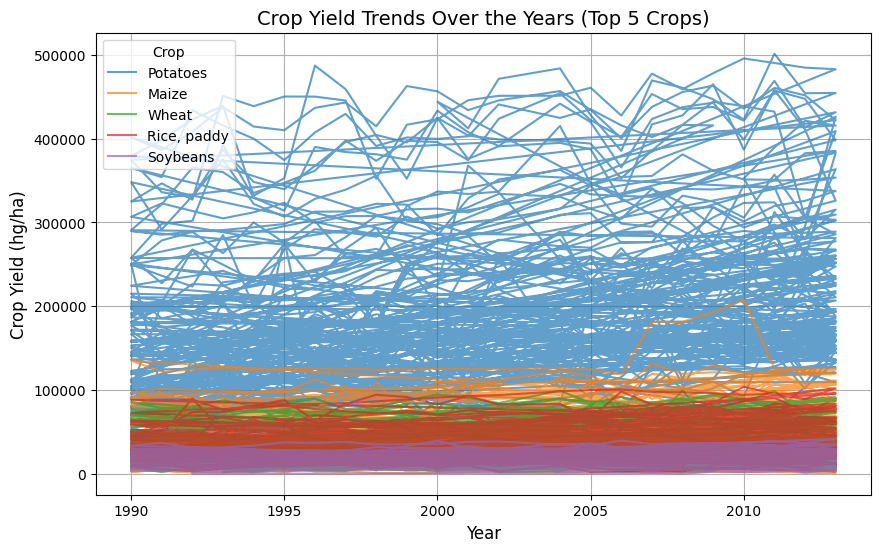

In [37]:

# Crop yield trends over the years for top 5 crops (by frequency)
top_crops = yield_df_cleaned['Item'].value_counts().head(5).index
crop_trends = yield_df_cleaned[yield_df_cleaned['Item'].isin(top_crops)]

plt.figure(figsize=(10, 6))
for crop in top_crops:
    subset = crop_trends[crop_trends['Item'] == crop]
    plt.plot(subset['Year'], subset['Value'], label=crop, alpha=0.7)

plt.title('Crop Yield Trends Over the Years (Top 5 Crops)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Crop Yield (hg/ha)', fontsize=12)
plt.legend(title="Crop")
plt.grid(True)
plt.show()

In [38]:
yield_df_cleaned

,Area,Item,Year,Value,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...
28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


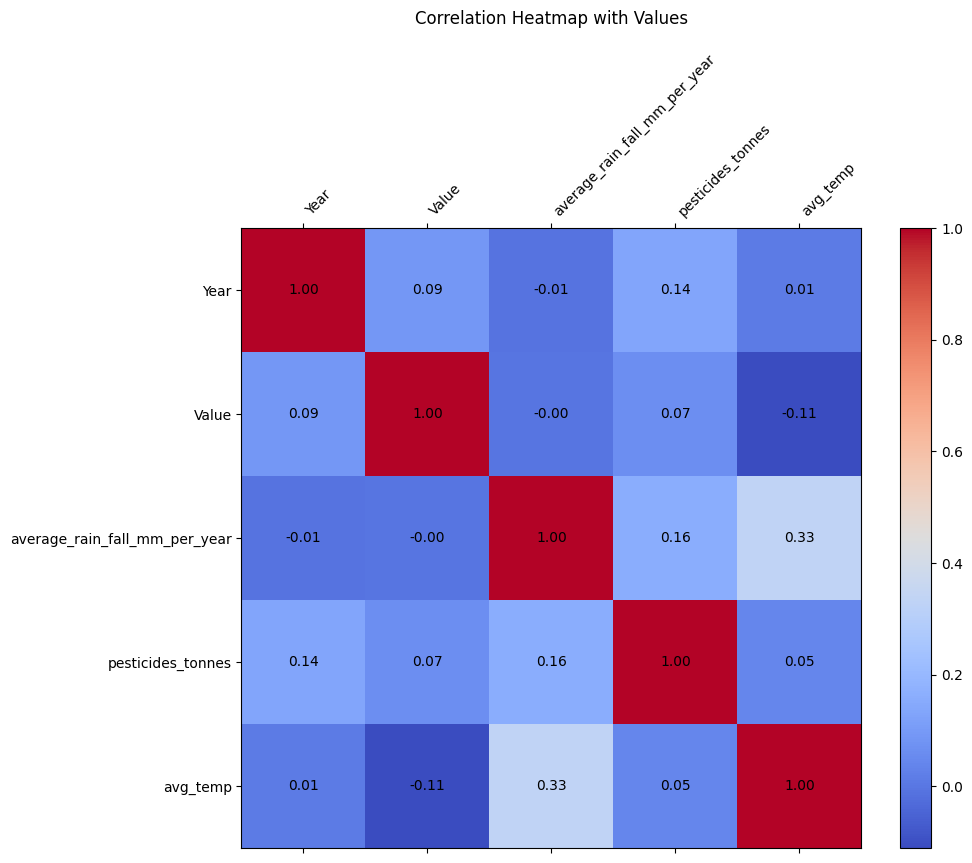

In [39]:
# Correlation heatmap of numerical features
correlation_matrix = yield_df_cleaned.select_dtypes(include='number').corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap = plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar(heatmap)

# Add the correlation values to the heatmap
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                 ha='center', va='center', color='black', fontsize=10)

# Set x and y ticks
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='left')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

plt.title('Correlation Heatmap with Values', pad=20)
plt.show()

In [40]:
unique_areas = yield_df_cleaned["Area"].unique().tolist()

In [41]:
unique_areas

['Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Botswana',
 'Brazil',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chile',
 'Colombia',
 'Croatia',
 'Denmark',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Eritrea',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'India',
 'Indonesia',
 'Iraq',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Kazakhstan',
 'Kenya',
 'Latvia',
 'Lebanon',
 'Lesotho',
 'Libya',
 'Lithuania',
 'Madagascar',
 'Malawi',
 'Malaysia',
 'Mali',
 'Mauritania',
 'Mauritius',
 'Mexico',
 'Montenegro',
 'Morocco',
 'Mozambique',
 'Namibia',
 'Nepal',
 'Netherlands',
 'New Zealand',
 'Nicaragua',
 'Niger',
 'Norway',
 'Pakistan',
 'Papua New Guinea',
 'Peru',
 'Poland',
 'Portugal',
 'Qatar',


In [42]:
unique_items = yield_df_cleaned["Item"].unique().tolist()

In [43]:
unique_items

['Maize',
 'Potatoes',
 'Rice, paddy',
 'Sorghum',
 'Soybeans',
 'Wheat',
 'Cassava',
 'Sweet potatoes',
 'Plantains and others',
 'Yams']

In [44]:
# One-hot encode categorical features
categorical_features = ['Area', 'Item']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(yield_df_cleaned[categorical_features])

C:\Users\ravis\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [45]:
# Normalize numerical features
numerical_features = ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(yield_df_cleaned[numerical_features])

In [46]:
# Combine all features into a single dataset
X = pd.concat(
    [
        pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features)),
        pd.DataFrame(scaled_numerical, columns=numerical_features),
    ],
    axis=1,
)

# Target variable
y = yield_df_cleaned['Value']

In [47]:
X.head()

,Area_Albania,Area_Algeria,Area_Angola,Area_Argentina,Area_Armenia,Area_Australia,Area_Austria,Area_Azerbaijan,Area_Bahamas,Area_Bahrain,...,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471388,-0.605681,-0.629302
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471388,-0.605681,-0.629302
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.471388,-0.605681,-0.629302
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.471388,-0.605681,-0.629302
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.471388,-0.605681,-0.629302


In [48]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20745, 114), (5187, 114), (20745,), (5187,))

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
cb_model = CatBoostRegressor(loss_function='RMSE')

# Train models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
cb_model.fit(X_train, y_train)

# Predictions
lr_preds = lr_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
cb_preds = cb_model.predict(X_test)

# Evaluate models
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)

rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

cb_mae = mean_absolute_error(y_test, cb_preds)
cb_r2 = r2_score(y_test, cb_preds)

Learning rate set to 0.066108
0:	learn: 80787.8172353	total: 7.21ms	remaining: 7.21s
1:	learn: 77381.8059894	total: 12.8ms	remaining: 6.41s
2:	learn: 74188.2925156	total: 19.2ms	remaining: 6.39s
3:	learn: 71235.0477635	total: 25.3ms	remaining: 6.3s
4:	learn: 68546.4686430	total: 30.9ms	remaining: 6.16s
5:	learn: 66019.5266334	total: 36.3ms	remaining: 6.02s
6:	learn: 63715.7691232	total: 41.6ms	remaining: 5.9s
7:	learn: 61673.0235664	total: 47.9ms	remaining: 5.94s
8:	learn: 59792.1140027	total: 54ms	remaining: 5.94s
9:	learn: 58046.7501274	total: 59.5ms	remaining: 5.89s
10:	learn: 56491.1134573	total: 64.9ms	remaining: 5.83s
11:	learn: 55056.3447323	total: 71.1ms	remaining: 5.86s
12:	learn: 53810.1161058	total: 76.9ms	remaining: 5.84s
13:	learn: 52606.6655295	total: 82.5ms	remaining: 5.81s
14:	learn: 51483.2414754	total: 88.3ms	remaining: 5.8s
15:	learn: 50310.6164555	total: 94.4ms	remaining: 5.81s
16:	learn: 49431.1660828	total: 101ms	remaining: 5.82s
17:	learn: 48598.7854756	total: 10

In [64]:
lr_mae, lr_r2, rf_mae, rf_r2, cb_mae, cb_r2

(30280.719298245614,
 0.7407266617785457,
 6312.721911744967,
 0.9664323485409428,
 10186.23913688692,
 0.9570794247673923)

C:\Users\ravis\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
def objective_rf(trial):
    # Hyperparameter suggestions
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    # Model with suggested hyperparameters
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Fit and evaluate
    rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    return mae

# Run Optuna study
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=50)

print("Best parameters for RandomForestRegressor:", study_rf.best_params)
print("Best MAE for RandomForestRegressor:", study_rf.best_value)

[I 2024-12-11 13:39:43,639] A new study created in memory with name: no-name-ad96a906-951f-4af1-a5c2-7da6fad4879f
[I 2024-12-11 13:40:05,023] Trial 0 finished with value: 17813.5417853712 and parameters: {'n_estimators': 205, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 12}. Best is trial 0 with value: 17813.5417853712.
[I 2024-12-11 13:41:04,538] Trial 1 finished with value: 11351.925135996999 and parameters: {'n_estimators': 395, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 16}. Best is trial 1 with value: 11351.925135996999.
[I 2024-12-11 13:41:33,124] Trial 2 finished with value: 15886.131495341202 and parameters: {'n_estimators': 253, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 13}. Best is trial 1 with value: 11351.925135996999.
[I 2024-12-11 13:42:54,760] Trial 3 finished with value: 6379.613820678501 and parameters: {'n_estimators': 312, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 

Best parameters for RandomForestRegressor: {'n_estimators': 499, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1}
Best MAE for RandomForestRegressor: 6300.6425307957825


In [65]:
def objective_cb(trial):
    # Hyperparameter suggestions
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-3, 10)
    iterations = trial.suggest_int('iterations', 100, 1000)
    
    # Model with suggested hyperparameters
    cb_model = CatBoostRegressor(
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        iterations=iterations,
        loss_function='RMSE',
        verbose=0,
        random_seed=42
    )
    
    # Fit and evaluate
    cb_model.fit(X_train, y_train)
    predictions = cb_model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    return mae

# Run Optuna study
study_cb = optuna.create_study(direction='minimize')
study_cb.optimize(objective_cb, n_trials=50)

print("Best parameters for CatBoostRegressor:", study_cb.best_params)
print("Best MAE for CatBoostRegressor:", study_cb.best_value)

[I 2024-12-11 14:42:40,348] A new study created in memory with name: no-name-fd93a012-5f9a-4d99-bc34-0263873d5d55
[I 2024-12-11 14:42:44,615] Trial 0 finished with value: 12646.953395704295 and parameters: {'depth': 5, 'learning_rate': 0.061839738073082226, 'l2_leaf_reg': 3.9091341490938394, 'iterations': 799}. Best is trial 0 with value: 12646.953395704295.
[I 2024-12-11 14:42:47,956] Trial 1 finished with value: 9081.80457943071 and parameters: {'depth': 5, 'learning_rate': 0.24378711577308676, 'l2_leaf_reg': 6.050466718993731, 'iterations': 619}. Best is trial 1 with value: 9081.80457943071.
[I 2024-12-11 14:42:49,920] Trial 2 finished with value: 15382.156489521767 and parameters: {'depth': 9, 'learning_rate': 0.055906692970725584, 'l2_leaf_reg': 0.2908503783839092, 'iterations': 147}. Best is trial 1 with value: 9081.80457943071.
[I 2024-12-11 14:42:51,288] Trial 3 finished with value: 11665.779242798546 and parameters: {'depth': 5, 'learning_rate': 0.258718960242733, 'l2_leaf_reg

Best parameters for CatBoostRegressor: {'depth': 10, 'learning_rate': 0.26479608137091015, 'l2_leaf_reg': 0.4843789935751785, 'iterations': 942}
Best MAE for CatBoostRegressor: 6737.0261830016925


In [66]:
from sklearn.ensemble import VotingRegressor
# Define the models with the optimized hyperparameters
rf_best = RandomForestRegressor(
    n_estimators=499,
    max_depth=30,
    min_samples_split=3,
    min_samples_leaf=1,
    random_state=42
)

cb_best = CatBoostRegressor(
    depth=10,
    learning_rate=0.26479608137091015,
    l2_leaf_reg=0.4843789935751785,
    iterations=942,
    random_seed=42,
    verbose=0,
    loss_function='RMSE'
)

# Create the Voting Regressor
voting_regressor = VotingRegressor([
    ('rf', rf_best),
    ('cb', cb_best)
])

# Train the Voting Regressor
voting_regressor.fit(X_train, y_train)

# Predictions and evaluation
voting_predictions = voting_regressor.predict(X_test)

# Evaluate metrics
voting_mae = mean_absolute_error(y_test, voting_predictions)
voting_r2 = r2_score(y_test, voting_predictions)

print("Voting Regressor MAE:", voting_mae)
print("Voting Regressor R²:", voting_r2)

Voting Regressor MAE: 6277.598394432359
Voting Regressor R²: 0.969186526594675


In [76]:
# Save the ensemble model
best_model_file = "voting.pkl"
joblib.dump(voting_regressor, best_model_file, compress=9)
print(f"Saved best model to {best_model_file}")

Saved best model to voting.pkl


In [77]:
joblib.__version__

'1.3.2'

In [69]:
test_prediction = voting_regressor.predict(X_test)

In [70]:
test_prediction

array([ 96563.49012445,  15174.56358212,  75420.89625115, ...,
        40253.32407869,  10098.29750822, 130918.46515453])

In [51]:
# from sklearn.model_selection import GridSearchCV

# # Define parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=42),
#     param_grid=param_grid,
#     cv=3,
#     scoring='neg_mean_absolute_error',
#     verbose=1,
#     n_jobs=-1
# )

# # Perform grid search
# grid_search.fit(X_train, y_train)

# # Best parameters and best score
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Evaluate the best model on the test set
# best_preds = best_model.predict(X_test)
# best_mae = mean_absolute_error(y_test, best_preds)
# best_r2 = r2_score(y_test, best_preds)

# best_params, best_mae, best_r2

In [68]:
#Save the one hot encoder
joblib.dump(encoder, 'one_hot_encoder.pkl')

# Save the scaler
joblib.dump(scaler, 'standard_scaler.pkl')

['standard_scaler.pkl']

In [57]:
# test_prediction = rf_model_best.predict(X_test)